# Homework 07

# Problem 2 <a name="introduction"></a>

## 26 <a name="26"></a>

We have a residual layer with the following reverse graph

To calculate $\frac{\partial e}{\partial x}$ we will need
to apply the chain rule through $f(x)$ and sum on the
residual merge. This gives

$$
\frac{\partial e}{\partial x} = 
    \frac{\partial f}{\partial x}
    \cdot
    \frac{\partial e}{\partial y} 
$$
## 27 

We apply the operator $\partial/\partial x$ across $\boldsymbol{e}$

$$
\begin{aligned}
\frac{\partial e}{\partial h-h_0} &= 
    \frac{\partial e(h)}{\partial h-h_0}
    +
    \frac{\partial (h-h_0)^T g}{\partial h-h_0}
    +
    0.5\frac{\partial (h-h_0)^T A (h-h_0)}{\partial h-h_0}
\\
&=0 + g + A(h-h_0)
\end{aligned}
$$

Then optimizing with this expression gives

$$
\begin{aligned}
0 + g + A(h-h_0) &= 0 \\
A(h-h_0) &= -g \\
h-h_0 &= -gA^{-1}
\end{aligned}
$$

## 28 

This one got me on the test, as I applied the chain rule to the optimized
$h-h_0$ found above rather than the gradient. It is more straightforward to
differentiate with respect to $\alpha$, giving

$$
\begin{aligned}
\frac{\partial e(h)}{\partial \alpha}
&=
0 - g^Tg + \alpha g^T A g
\end{aligned}
$$

Which we optimize as

$$
\begin{aligned}
- g^Tg + \alpha g^T A g &= 0 \\
g^Tg = \alpha g^T A g \\
\alpha = \frac{g^Tg}{g^T A g} \\
\end{aligned}
$$

# Training

I could not find a logical way to divide the document where each problem
was encapsulated separately, but I have done my best to answer the given questions in the order that the occur during network design.

The Tiny ImageNet dataset can be downloaded 
[here](http://cs231n.stanford.edu/tiny-imagenet-200.zip)
Extract the zip onto a fast disk drive. First we will set up the
python environment and imports, along with model flags.

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tf import keras
from tf.keras import layers
import os
import re
from IPython.display import clear_output

from tf.keras.callbacks import ModelCheckpoint, ProgbarLogger
from tf.losses import sparse_softmax_cross_entropy as softmax_xent
from tf.data import TFRecordDataset
from tf.data.experimental import TFRecordWriter
from tf.keras.preprocessing.image import ImageDataGenerator

# For TFRecord demo
tf.logging.set_verbosity(tf.logging.INFO)

# Only expose secondary GPU
# Prevents desktop sluggishness
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

class Constants(object):
    def __init__(self, d):
        self.__dict__ = d

# Constants for important filepaths
DATASET_ROOT = '/home/tidal/tiny-imagenet-200'
FLAGS = {
    # Dataset / Sharding
    'train_dir' : 'train',
    'tfrecord_fmt' : 'tfrecords/tin_{}.tfrecord',
    'num_classes' : 200,
    'num_shards' : 10,
    'shard_size' : 10000,
    'num_train' : 100000,
    'input_shape' : (64, 64, 3),
    'data_format' : 'channels_last',
    'class_mode' : 'sparse',
    'compression' : 'GZIP',

    # Preprocessing args for ImageDataGenerator
    'preprocess' : {
        'samplewise_center' : True,
        'samplewise_std_normalization' : True,
        'horizontal_flip' : True,
        'rescale' : 1./255
    },

    # Model
    'width' : 64,

    # Training
    'batch_size' : 128,
    'num_epochs' : 72,
    'shuffle' : 5000,
    'momentum' : 0.9,
    'regularizer_scale' : 0.1,
    'lr_initial' : 0.01,
    'lr_scale' : 0.1,
    'lr_epoch' : 64,
    'val_size' : 5000,
    'lr_staircase' : True,

    # Checkpoint
    'max_checkpoint' : 5,
    'chkpt_fmt' : 'checkpoints/resnet_{epoch:02d}'
}

# Append full paths
for path in ['train_dir', 'tfrecord_fmt', 'chkpt_fmt']:
    base = FLAGS[path]
    FLAGS[path] = os.path.join(DATASET_ROOT, base)

# Allow for FLAGS.x indexing
FLAGS = Constants(FLAGS)

# Input shape, batching, and data type
inputs = tf.keras.layers.Input(
    shape=FLAGS.input_shape,
    name='input',
    dtype=tf.float32
)

# Ground truth sparse label placeholder
labels = tf.placeholder(
    dtype=tf.int32,
    shape=[None],
    name='label'
)

## Importing the Dataset

Looking at the directory
structure of the dataset, we see that there are subdirectory for
training, validating, and testing. The training set contains
200 classes where images of a class are grouped by directory.

We can import the training set with preprocessing as follows
(documentation available 
[here](https://keras.io/preprocessing/image/).)

We will use the `ImageDataGenerator`. This works well on the
training set by default, and will automate nearly all of the
import process. First a generator is constructed as follows

In [ ]:
train_datagen = ImageDataGenerator(
        data_format=FLAGS.data_format,
        **FLAGS.preprocess)


where the arguments (some found in `FLAGS.preprocess) are
 * `samplewise_center=True` - Normalize to zero mean
 * `samplewise_std_normalization=True` - Normalize to unit variance
 * `horizontal_flip=True` - Flip images
 * `data_format=True` - Generator should yield images with channels on axis 0
 * `rescale=1./255` - Rescale 8 bit images to a float on [0, 1]

The constructor also allows one to specify a custom preprocessing function to run after the above operations. However, it is worth noting that these arithmetic operations will result in floating point outputs. Unless we are willing to tolerate a loss of precision by rounding these floats back to bytes, we will see a noticable growth in the size of our `.tfrecord` files. 
This also has implications for memory movement, as we are now moving around additional floating point values.

An alternative is to apply these preprocessing operations as the `.tfrecord` file is read, at which point computational cost is traded for memory and storage efficiency.

Next we use the `flow_from_directory` method which automatically
interprets the file structure of the training set and returns an iterator
over training files. Our preprocessing operations will be applied as files are pulled from this iterator as tuples of image label pairs. The arguments are mostly trivial. We specify a `class_mode='sparse'` such that an argmax integer is produced for labels, rather than a one hot vector. The batch size specified here is distinct from the one used in training and may be tuned separately.

For other class modes, be sure to choose a loss function accordingly. Using categorical labels with sparse loss functions will produce cryptic errors about type and length. 

In [ ]:
train_generator = train_datagen.flow_from_directory(
        FLAGS.train_dir,
        target_size=FLAGS.input_shape[:2],
        batch_size=FLAGS.shard_size,
        class_mode=FLAGS.class_mode)
train_generator

When we invoke `train_generator` we see output on the properties of the scanned dataset.

**Note** that no shuffling was used - according to the documentation,
shuffling should be done after any sharding operations.

**Note** `train_generator` is assigned once, outside of any looping operations. If the iterator has stateful dependencies, it will be regenerated numerous times in the dataflow graph, leading to inefficiency and the possiblity that only some of the training examples will be pulled by the iterator.

## Writing `.tfrecord` files

We write `.tfrecord` files by serializing features and labels to binary 
strings and writing those strings to appropriate files. Specifically,
we do the following:

 1. Wrap the iterator we just created into a `Dataset` using `from_generator()`
 2. Constrain the dataset to a finite size, as iterators loop indefinitely
 3. Use `flat_map` to flatten out batching produced by the iterator
 4. Serialize the image and label tensors to binary string
 5. Pack those binary strings into an `Example` which can be serialized to
    a string representing the complete training example
 6. Write the serialized example to a file

First we define the graph of these operations as follows

In [148]:

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def serialize_example(img, label):
    # Dict of features for the serialized Example
    feature = {
        'img': _bytes_feature(img),
        'label': _bytes_feature(label),
    }

    # Serialize and return
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def serialize_tensors(img, label):
    # Serialize the image and label tensors
    serial_img = tf.serialize_tensor(img)
    label = tf.serialize_tensor(label)

    tf_string = tf.py_func(
        serialize_example, 
        (serial_img, label),  
        tf.string)      
    return tf.reshape(tf_string, ())

#count = tf.Variable(0, dtype=tf.int32)

_ = tf.data.Dataset.from_generator(
        lambda : train_generator,
        output_types=(tf.float32, tf.uint8)
)
_ = _.take(len(train_generator))
_ = _.flat_map( lambda x, y : tf.data.Dataset.from_tensor_slices((x,y)))
raw_data = _.map(serialize_tensors, num_parallel_calls=8)

And then we execute this graph. This operation may take a long time, and
the shard files may be large. In total the dataset grew to over a gigabyte
even when using compression.

In [ ]:
with tf.Session() as session:
    file_list = []
    for shard_index in range(FLAGS.num_shards):
        filename = FLAGS.tfrecord_fmt.format(shard_index)
        writer = TFRecordWriter(filename, compression_type=FLAGS.compression)
        shard = raw_data.shard(FLAGS.num_shards, shard_index)
        print('Writing shard %i / %i' % (shard_index+1, FLAGS.num_shards))
        session.run(writer.write(shard))
        file_list.append(filename)

    print('Wrote files:')
    for f in file_list:
        print('  |-- %s' % os.path.basename(f))


Writing shard 1 / 10
Writing shard 2 / 10
Writing shard 3 / 10
Writing shard 4 / 10
Writing shard 5 / 10
Writing shard 6 / 10
Writing shard 7 / 10
Writing shard 8 / 10
Writing shard 9 / 10


## Reading `.tfrecord` files

We essentially perform the reverse of the serialization operations used to
write the records.

In [ ]:
# The features to extract from a record

def deserialize_example(example):
    features = {
           'img': tf.FixedLenFeature(shape=[], dtype=tf.string),
           'label': tf.FixedLenFeature(shape=[], dtype=tf.string)
    }
    example = tf.parse_single_example(example, features)
    img, label = example['img'], example['label']

    img = tf.parse_tensor(img, tf.float32)
    img = tf.reshape(img, FLAGS.input_shape)

    label = tf.parse_tensor(label, tf.uint8)
    label = tf.reshape(label, ())
    return img, label

# Construct a dataset of serialized records
filenames = tf.data.Dataset.list_files(FLAGS.tfrecord_fmt.format('*'))
_ = tf.data.TFRecordDataset(filenames, compression_type=FLAGS.compression)

# Deserialize dataset to original tensors
_ = _.map(deserialize_example)

# Select training/validation sets with skip/take
# Repeat to create a looping dataset
# Batch as desired
ds_train = _.skip(FLAGS.val_size)
            .repeat()
            .batch(FLAGS.batch_size)

ds_val = _.take(FLAGS.val_size)
        .repeat()
        .batch(FLAGS.batch_size)

We can then verify that we are reconstructing sane images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


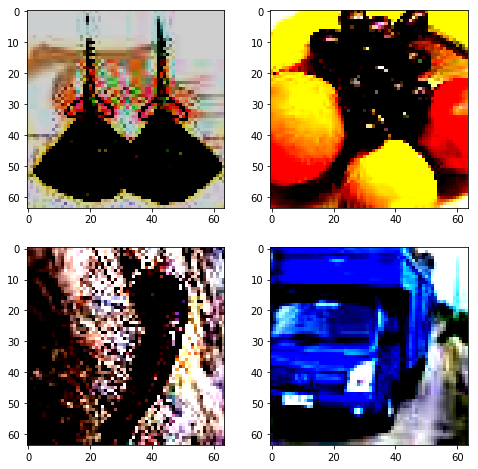

In [151]:
with tf.Session() as session:
    _ = ds_val.take(1).map(
        lambda x, y : tf.py_func(
            plot_images,
            [x],
            tf.float32
        )
    )
    session.run(_.make_one_shot_iterator().get_next())

## Building the Model

We can construct Resnet using a subclassed approach. This involves
creating modular blocks of layers that can be reused as needed, thus
increasing code reuseability and ease of maintainance. 

Specifically, we subclass `tf.keras.Model` and implement the methods
`__init__()` and `call()`. Our choice of `__init__()` method will define
the the types of layers in this block, but says nothing about how they
are connected. In the `call()` method we will define the connections
between layers. This method takes an input as a parameter and returns
an ouput that represents the feature maps after a forward pass through
all layers in the block.

The training state needed by layers like batch-norm is passed via
`**kwargs` in `call()`. Names are used for layers where possible to
simply debugging.

## Tail

We can begin by constructing the tail.

In [156]:
class Tail(tf.keras.Model):

    def __init__(self, Ni, *args, **kwargs):
        super(Tail, self).__init__(*args, **kwargs)

        # Big convolution layer
        self.conv = layers.Conv2D(
                Ni,
                (7, 7),
                padding='same',
                data_format=FLAGS.data_format,
                use_bias=False,
                name='tail_conv')

        # Tail BN
        self.bn = layers.BatchNormalization(
                name='tail_bn')

        # Tail BN
        self.relu = layers.ReLU(name='tail_relu')

        # Max pooling layer
        self.pool = layers.MaxPool2D(
                Ni,
                (2, 2),
                padding='same',
                data_format=FLAGS.data_format,
                name='tail_pool')

    def call(self, inputs, **kwargs):

        # Residual forward pass
        _ = self.conv(inputs, **kwargs)
        _ = self.bn(_, **kwargs)
        _ = self.relu(_, **kwargs)
        return self.pool(_, **kwargs)


## Basic Block 

Next we define the fundamental CNN style 2D convolution block
of Resnet, ie batch-norm, relu, convolution.

Note that the number of filters and the kernel size are 
parameterized, and that parameter packs `*args, **kwargs`
are forwarded to the convolution layer. This is important
as it enables the reuse of this model for the various
types of convolutions that we will need.

In [ ]:
class ResnetBasic(tf.keras.Model):

    def __init__(self, filters, kernel_size, strides=(1,1), *args, **kwargs):
        super(ResnetBasic, self).__init__(*args, **kwargs)
        self.batch_norm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        self.conv2d = layers.Conv2D(
                filters,
                kernel_size,
                padding='same',
                data_format=FLAGS.data_format,
                activation=None,
                use_bias=False,
                strides=strides)

    def call(self, inputs, **kwargs):
        x = self.batch_norm(inputs, **kwargs)
        x = self.relu(x, **kwargs)
        return self.conv2d(x, **kwargs)

## Standard Bottleneck

From `ResnetBasic` we can build the bottleneck.

In [ ]:
class Bottleneck(tf.keras.Model):

    def __init__(self, Ni, *args, **kwargs):
        super(Bottleneck, self).__init__(*args, **kwargs)

        # Three residual convolution blocks
        kernels = [(1, 1), (3, 3), (1, 1)]
        feature_maps = [Ni // 4, Ni // 4, Ni]
        self.residual_filters = [
            ResnetBasic(N, K) 
            for N, K in zip(feature_maps, kernels) 
        ] 

        # Merge operation
        self.merge = layers.Add()

    def call(self, inputs, **kwargs):

        # Residual forward pass
        res = inputs
        for res_layer in self.residual_filters:
            res = res_layer(res, **kwargs)

        # Combine residual pass with identity
        return self.merge([inputs, res], **kwargs)

## Special Bottleneck

We can define the special bottleneck layer by subclassing
the `Bottleneck` class as follows.

In [ ]:
class SpecialBottleneck(Bottleneck):

    def __init__(self, Ni, *args, **kwargs):

        # Layers that also appear in standard bottleneck
        super(SpecialBottleneck, self).__init__(Ni, *args, **kwargs)

        # Add convolution layer along main path
        self.main = layers.Conv2D(
                Ni,
                (1, 1),
                padding='same',
                data_format=FLAGS.data_format,
                activation=None,
                use_bias=False)

    def call(self, inputs, **kwargs):

        # Residual forward pass
        res = inputs
        for res_layer in self.residual_filters:
            res = res_layer(res, **kwargs)

        # Convolution on main forward pass
        main = self.main(inputs, **kwargs)

        # Merge residual and main
        return self.merge([main, res])

## Downsampling

Next we need to define the downsampling layer.

In [ ]:
class Downsample(tf.keras.Model):

    def __init__(self, Ni, *args, **kwargs):
        super(Downsample, self).__init__(*args, **kwargs)

        # Three residual convolution blocks
        kernels = [(1, 1), (3, 3), (1, 1)]
        strides = [(2, 2), (1, 1), (1, 1)]
        feature_maps = [Ni // 2, Ni // 2, 2*Ni]

        self.residual_filters = [
            ResnetBasic(N, K, strides=S) 
            for N, K, S in zip(feature_maps, kernels, strides) 
        ] 

        # Convolution on main path
        self.main = ResnetBasic(2*Ni, (1,1), strides=(2,2))

        # Merge operation for residual and main
        self.merge = layers.Add()

    def call(self, inputs, **kwargs):

        # Residual forward pass
        res = inputs
        for res_layer in self.residual_filters:
            res = res_layer(res,**kwargs)

        # Main forward pass
        main = self.main(inputs, **kwargs)

        # Merge residual and main
        return self.merge([main, res])

## Final Model

Finally, we can assemble these blocks into the final model. 
Note that `Keras` provides a variety of simple ways to tweak
the model, such as adding regularization. In fact, one could
probably construct the model and override layers as member variables
to apply tweaks without altering the main class. Subclassing is
another option.

In [ ]:
class Resnet(tf.keras.Model):

    def __init__(self, classes, filters, levels, *args, **kwargs):
        super(Resnet, self).__init__(*args, **kwargs)


        # Lists to hold various layers
        self.blocks = list()

        # Tail
        self.tail = Tail(filters)

        # Special bottleneck layer with convolution on main path
        self.level_0_special = SpecialBottleneck(filters)

        # Loop through levels and their parameterized repeat counts
        for level, repeats in enumerate(levels):
            for block in range(repeats):
                # Append a bottleneck block for each repeat
                name = 'bottleneck_%i_%i' % (level, block)
                layer = Bottleneck(filters, name=name)
                self.blocks.append(layer)

            # Downsample and double feature maps at end of level
            name = 'downsample_%i' % (level)
            layer = Downsample(filters, name=name)
            self.blocks.append(layer) 
            filters *= 2

        self.level2_batch_norm = layers.BatchNormalization(name='final_bn')
        self.level2_relu = layers.ReLU(name='final_relu')

        # Decoder - global average pool and fully connected
        self.global_avg = layers.GlobalAveragePooling2D(
                data_format=FLAGS.data_format,
                name='GAP' 
                )

        # Dense with regularizer, just as a test
        self.dense = layers.Dense(
                classes, 
                name='dense',
                kernel_regularizer=tf.keras.regularizers.l2(0.01),
                use_bias=True)


    def call(self, inputs, **kwargs):
        x = self.tail(inputs, **kwargs)
        x = self.level_0_special(x)

        # Loop over layers by level
        for layer in self.blocks:
            x = layer(x, **kwargs)

        # Finish up specials in level 2
        x = self.level2_batch_norm(x, **kwargs)
        x = self.level2_relu(x)

        # Decoder
        x = self.global_avg(x)
        return self.dense(x, **kwargs)

## Using the Model

Now that we have defined a subclassed model, we need to
incorproate it into a training / testing environment. This is
where the beauty of the subclassed approach comes in. 
In our case
we want construct Resnet modified for Tiny Imagenet, where the
modifications are as follows:

 * Third level of residual blocks + downsampling
 * Full and half width versions

Our Resnet class accepts an interable of integers to define the
number of repeats at each level. As such, we need only add an
integer for the number of repeats at level 3 to our constructor call.
Similarly, we can scale the number of feature maps as needed to adjust
width.


In [ ]:
# As seen in CIFAR
standard_levels = [4, 6, 3]

# Add our new level
new_level_count = 2
modified_levels = standard_levels + [new_level_count]

model = Resnet(FLAGS.num_classes, FLAGS.width, modified_levels)
outputs = model(inputs)

Note that `model` returned by our class constructor is callable.
Thus our forward pass mapping inputs to outputs is invoked by
"calling" `model` on the inputs and storing the returned outputs.
The operation above defines this flow of information as part of
a computational graph but does not carry out operations yet.

Finally, we can get a summary of model

In [159]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bottleneck_0_0 (Bottleneck)  (None, 32, 32, 64)        4736      
_________________________________________________________________
bottleneck_0_1 (Bottleneck)  (None, 32, 32, 64)        4736      
_________________________________________________________________
bottleneck_0_2 (Bottleneck)  (None, 32, 32, 64)        4736      
_________________________________________________________________
bottleneck_0_3 (Bottleneck)  (None, 32, 32, 64)        4736      
_________________________________________________________________
downsample_0 (Downsample)    (None, 16, 16, 128)       24320     
_________________________________________________________________
bottleneck_1_0 (Bottleneck)  (None, 16, 16, 128)       18176     
_________________________________________________________________
bottleneck_1_1 (Bottleneck)  (None, 16, 16, 128)       18176     
__________

## Training Prep

We define an accuracy and loss metric, as well as an optimizer.
The model is then compiled before execution.

In [ ]:
metrics = ['sparse_categorical_accuracy']

# Need wrapper to cast argmax labels from float to int?
def ssce(labels, logits, *args, **kwargs):
    labels = tf.cast(labels, tf.int32)
    return tf.losses.sparse_softmax_cross_entropy(labels, logits)
loss = ssce

optimizer = tf.train.AdamOptimizer(
        learning_rate=FLAGS.lr_initial
)

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

We can optionally add callbacks to handle checkpointing, learning rate
changes, and other operations.

In [170]:
checkpoint = ModelCheckpoint(
        filepath=FLAGS.chkpt_fmt, 
        period=1,
        save_weights_only=True
)

callbacks = [ 
        checkpoint
]

We can conduct a few sanity checks before starting the training
process. Let us evaluate our untrained model and examine the accuracy.
We know that there are 200 labels, so by random guessing we expect an
accuracy of about 1/200.

In [171]:
z = model.evaluate(ds_val, steps=10)
_, _ = z
expect = 1. / FLAGS.num_classes
print('Expected: %0.3f, actual: %0.3f' % (expect, _))

10/10 [==============================] - 10s 970ms/step
Expected: 0.005, actual: 0.005


## Training

First we will check for checkpoints from which we can initialize weights.
If none were found this may be a good place to apply some other
initialization strategy.

In [172]:
_ = FLAGS.chkpt_fmt.format(epoch=0)
_ = os.path.dirname(_)
checkpoint_dir_contents = sorted(os.listdir(_))
if checkpoint_dir_contents:
    print('Trying checkpoint %s' % checkpoint_dir_contents[0])
    model.load_weights(checkpoint_dir_contents[0])
else:
    print('No checkpoint files found')

No checkpoint files found


And now we begin the training loop. Statistics and progress will be
printed regularly. The call to `model.fit()` will return a history with
metrics over the epochs.

In [ ]:
steps_per_epoch = (FLAGS.num_train-FLAGS.val_size) // FLAGS.batch_size

history = model.fit(
        ds_train,
        epochs=FLAGS.num_epochs,
        callbacks=callbacks,
        validation_data=ds_val,
        shuffle=True,
        steps_per_epoch=steps_per_epoch,
        validation_steps=FLAGS.val_size // FLAGS.batch_size
)
print(history)

Epoch 1/72
742/742 [==============================] - 725s 977ms/step - loss: 5.1228 - sparse_categorical_accuracy: 0.0184 - val_loss: 5.1833 - val_sparse_categorical_accuracy: 0.0296
Epoch 2/72
 46/742 [>.............................] - ETA: 10:32 - loss: 4.7560 - sparse_categorical_accuracy: 0.0387